### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.stats.diagnostic as diag
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import normaltest
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

random_state = 42

/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_37148/435324303.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Data Upload

In [2]:
df = pd.read_csv('./data/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### Data Preprocessing

#### Handling Missing Values

In [3]:
# Remove rows with missing values in 'MasVnrType', 'MasVnrArea', and 'Electrical' columns.
df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'], inplace=True)

In [4]:
# Impute missing LotFrontage values based on the median LotFrontage within each neighborhood.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [5]:
# Fill missing values in FireplaceQu with 'None'.
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

In [6]:
# Fill missing values in garage-related variables with 'None'.
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')

In [7]:
# Fill missing values in basement-related variables with 'None'.
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [8]:
# Drop columns with a high count of missing values
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

#### Encoding

In [9]:
nominalFeatures = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                    'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType',
                    'SaleCondition','PavedDrive']

ordinalFeatures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu',
                    'GarageQual', 'GarageCond']

otherOrdinalFeatures = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish']

In [10]:
df = pd.get_dummies(df, columns = nominalFeatures)

In [11]:
ordinalCategories = [['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'] for _ in ordinalFeatures]

ordinalEncoder = OrdinalEncoder(categories=ordinalCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[ordinalFeatures])

for i, feature in enumerate(ordinalFeatures):
    df[feature] = ordinalEncoded[:, i]

In [12]:
encodingCategories = [
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
]

ordinalEncoder = OrdinalEncoder(categories=encodingCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[otherOrdinalFeatures])

for i, feature in enumerate(otherOrdinalFeatures):
    df[feature] = ordinalEncoded[:, i]

#### Splitting DataSet

In [13]:
df_cp = df.copy()
y = df_cp.pop('SalePrice')
X = df_cp

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [15]:
print(X_train.shape)
print(X_test.shape)

(470, 191)
(118, 191)


### Decision Tree

In [16]:
clf = DecisionTreeClassifier(max_depth=4, random_state=random_state) 
clf = clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

[Text(0.49107142857142855, 0.9, 'KitchenQual <= 3.5\ngini = 0.995\nsamples = 470\nvalue = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2\n1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1\n1, 1, 1, 4, 1, 1, 1, 1, 1, 6, 1, 2, 1, 2\n3, 1, 1, 3, 1, 5, 1, 1, 4, 3, 2, 1, 4, 1\n1, 1, 1, 2, 5, 1, 1, 1, 1, 2, 1, 1, 1, 2\n2, 1, 6, 1, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1\n5, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2\n1, 1, 2, 1, 3, 2, 1, 2, 2, 1, 1, 4, 2, 1\n3, 1, 2, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1\n5, 1, 2, 1, 1, 2, 1, 4, 1, 1, 3, 3, 6, 1\n3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2\n1, 1, 2, 1, 2, 2, 3, 1, 1, 1, 1, 2, 1, 1\n3, 1, 5, 1, 3, 1, 1, 1, 3, 1, 1, 3, 2, 1\n1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1\n1, 1, 3, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1\n1, 1, 3, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1\n1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1\n2, 1, 3, 1, 1, 1, 1, 1, 3, 1, 5, 1, 1, 1\n2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2\n1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1\n1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1\n1, 1, 1, 1, 1, 1, 1, 1, 1, 

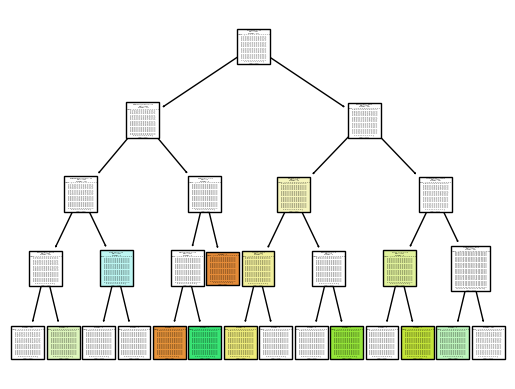

In [17]:
tree.plot_tree(clf,feature_names=df.columns, class_names=True, filled=True )

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print ("Precision:", metrics.precision_score(y_test,y_pred,average='weighted') )
print ("Recall: ", metrics.recall_score(y_test,y_pred,average='weighted'))

Accuracy: 0.01694915254237288
Precision: 0.004417598269022719
Recall:  0.01694915254237288


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
depths = [3, 5, 10]

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Results for max depth = {depth}:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    print("------------------------------------------------")


Results for max depth = 3:
MSE: 2991950907.527589
MAE: 36760.9255086387
R²: 0.6696734506076347
------------------------------------------------
Results for max depth = 5:
MSE: 3306313954.971548
MAE: 38258.50514719189
R²: 0.6349661763480974
------------------------------------------------
Results for max depth = 10:
MSE: 3159607721.3188004
MAE: 36568.43451368511
R²: 0.6511632883444665
------------------------------------------------


Basado en los resultados, cada modelo tiene su propio conjunto de compensaciones.
- Con una profundidad máxima de 3, el modelo tiene la complejidad más baja. Tiene el mejor valor R² entre los tres, lo que indica un ajuste relativamente bueno a los datos a pesar de su simplicidad.
- Con una profundidad de 5, es evidente que es más complejo que el anterior porque muestra una disminución en el rendimiento según el valor R², lo que indica un ajuste ligeramente peor a los datos. Tiene el MSE y MAE más altos, lo que sugiere más errores en sus predicciones.
- El modelo más complejo, con una profundidad de 10, muestra una mejora con respecto al modelo de profundidad 5 en términos de MSE, MAE y R². Se encuentra en un punto medio entre los dos primeros modelos en términos tanto de métricas de error como de ajust

Con el análisis anterior, el mejor modelo sería con profundidad 3. Esto porque es el que presenta el valor más alto de R², lo que indica que es el que mejor explica la variabilidad de los precios de las casas. Aunque su MSE y MAE son ligeramente más altos en comparación con el modelo de profundidad 10, el mayor valor de R² sugiere que tiene una mejor capacidad de generalización.